In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from analysis import DataProcessor

In [2]:
embedding = pd.read_csv('results/s5.csv')
finance = pd.read_csv('finance.csv',index_col=0)
loss = pd.read_csv('results/loss.csv')
price = pd.read_csv('sp500.csv',index_col=0)

In [3]:
embedding.index = pd.read_csv('Y_bert.csv',index_col=0).columns.values[:len(embedding)]
for name in finance.index.values:
    try:
        finance.at[name,"beta"] = float(finance.at[name,"beta"])
    except:
        finance.at[name,"beta"] = np.nan
    try:
        finance.at[name,"per"] = np.log(float(finance.at[name,"per"]))
    except:
        finance.at[name,"per"] = np.nan

In [4]:
def plot_pca(data, i, j):
    pca = PCA().fit(data)
    pca_data = pca.transform(data)
    pc1 = pca_data[:, i-1]
    pc2 = pca_data[:, j-1]

    plt.figure(figsize=(6, 6))
    plt.scatter(pc1, pc2, s=0.1)
    for k, (x, y) in enumerate(zip(pc1, pc2)):
        plt.text(x, y, data.index[k], fontsize=9, ha='right')
    plt.axhline(0, color='grey', lw=0.5); plt.axvline(0, color='grey', lw=0.5); plt.grid(True)
    plt.xlabel(f'PC{i}'); plt.ylabel(f'PC{j}'); plt.title('Stock Embedding after PCA')
    plt.show()

In [5]:
def plot_ecdf(dataframe):
    standardized_df = (dataframe - dataframe.mean()) / dataframe.std()
    plt.figure(figsize=(6, 6))
    for column in standardized_df.columns:
        sns.ecdfplot(standardized_df[column], color='lightgray', lw=1, 
                     label='Extracted Features' if column == standardized_df.columns[0] else None)
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, norm.cdf(x), color='blue', lw=2, label='Standard Normal')
    plt.xlabel('Standardized Value'); plt.ylabel('Cumulative Probability'); plt.grid(True)
    plt.title('Empirical CDFs of 50 Extracted Features'); plt.legend(title='Distribution', loc='lower right')
    plt.show()

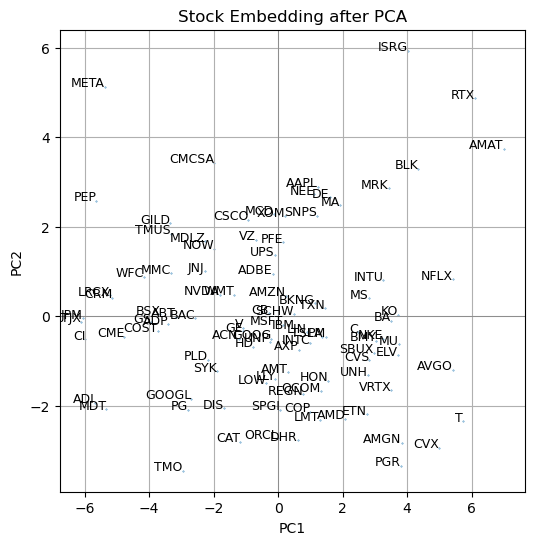

In [6]:
plot_pca(embedding,1,2)

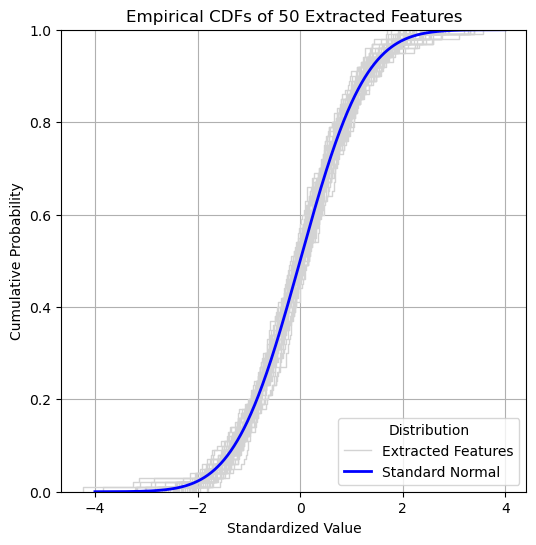

In [7]:
plot_ecdf(embedding)

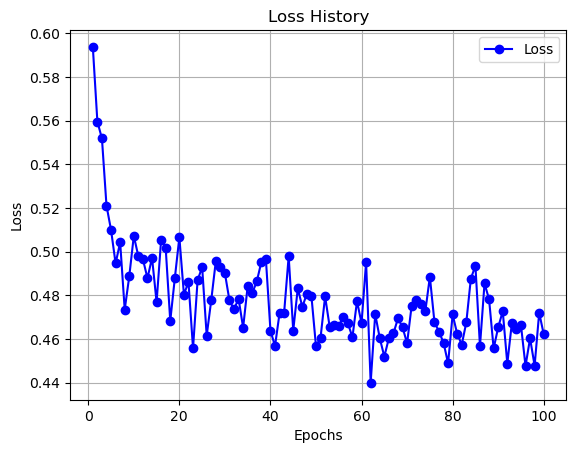

In [8]:
loss_values = loss["s5"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.title('Loss History'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

C:\Users\sizum\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\sizum\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

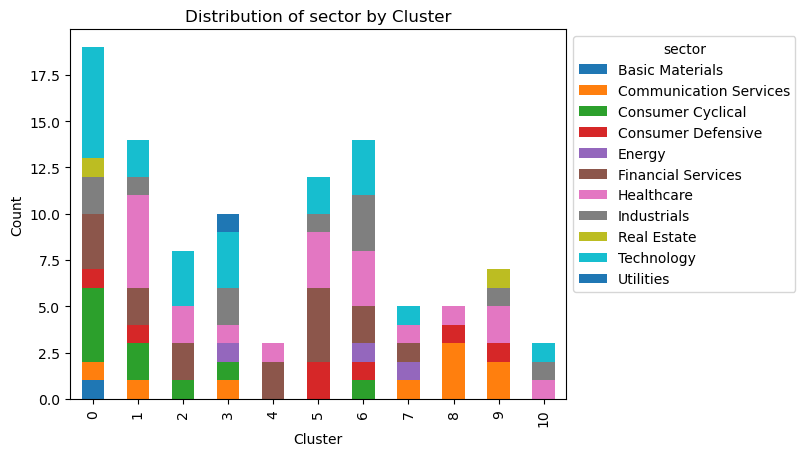

In [9]:
processor = DataProcessor()
processor.fit(embedding, finance, K=11)
processor.plot_feature('sector')

In [10]:
moves = price.pct_change().loc["2023/01/01":,embedding.index.values]
div1 = pd.DataFrame(np.zeros(11*len(moves)).reshape(len(moves),11),index=moves.index)
div2 = pd.DataFrame(np.zeros(11*len(moves)).reshape(len(moves),11),index=moves.index)
div3 = pd.DataFrame(np.zeros(11*len(moves)).reshape(len(moves),11),index=moves.index)

subfinance = finance.loc[embedding.index,:]
for i,s in enumerate(list(set(subfinance["sector"]))):
    name = list(subfinance[subfinance.sector==s].index)
    div1.iloc[:,i] = moves.loc[:,name].mean(axis=1)
for i in range(11):
    name = processor.get_ticker_incluster(i)
    div2.iloc[:,i] = moves.loc[:,name].mean(axis=1)
random_list = random.sample(list(range(100)),100)
c = 0
for i in range(1,12):
    name = []
    for j in random_list[c:i*9+1]:
        name.append(list(embedding.index.values)[j])
    c = i*9+1
    div3.iloc[:,i-1] = moves.loc[:,name].mean(axis=1)
    
def corr_list(div):
    n = div.shape[1]
    cor = div.corr()
    corr = []
    for i in range(n-1):
        for j in range(i+1,n):
            corr.append(cor.iloc[i,j])
    return corr

cor1 = corr_list(div1)
cor2 = corr_list(div2)
cor3 = corr_list(div3)

In [11]:
print([np.mean(cor1),np.mean(cor2),np.mean(cor3)])

[0.41940234737382914, 0.6943946762696035, 0.7321576878629077]
